# Transforming the data

## Recap

Last time we wrote a Source dataset. Here's the final version:

In [1]:
from pathlib import Path
from connectome import Source, meta
import imageio


class HeLa(Source):
    _root: str
    
    def _base(_root):
        return Path(_root)
    
    @meta
    def ids(_base):
        return sorted({str(f.relative_to(_base)) for f in _base.glob('*/*.tif')})
    
    def image(key, _base):
        return imageio.imread(_base / key)
    
    def mask(key, _base):
        path = key.replace('/t', '_ST/SEG/man_seg')
        return imageio.imread(_base / path)

In [2]:
source = HeLa(root='DIC-C2DH-HeLa')
key = source.ids[0]
x, y = source.image(key), source.mask(key)

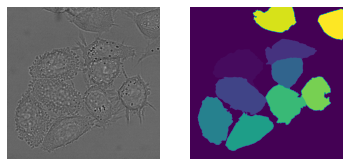

In [3]:
import matplotlib.pyplot as plt

plt.subplot(1, 2, 1)
plt.imshow(x, cmap='gray')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(y)
plt.axis('off');

Now we'll apply some preprocessing.

# Making the mask binary

Suppose we want to solve a semantic segmentation task. In this case we need to make the masks binary. We'll use a `Transform` for that. Transforms describe how various fields of your data entries should be changed:

In [4]:
from connectome import Transform


class Binarize(Transform):
    def mask(mask):
        return mask > 0

Ok, let's try to understand what's happening here step by step:

1. ```python
def mask(...):
```

The function's name is the **output** name of the field, so this function describes how the `mask` will look after we apply the transform.

2. ```python
def ...(mask):
```

The function's arguments denote what fields it requires from the **previous** layer.

So, this

```python
def mask(mask):
```

says "to compute the output `mask`, I need the `mask` from the previous layer"


Now let's apply this transform to our data:

In [5]:
from connectome import Chain

dataset = Chain(
    source, Binarize(),
)

`Chain` combines multiple layers in a sequential manner. You can also use the `>>` operator as a shortcut:

In [6]:
dataset = source >> Binarize()

we have the following fields:

In [7]:
dir(dataset)

['id', 'ids', 'mask']

Where did the `image` go?

Well, one of the basic principles of `connectome` is _data consistency_: after each transform each entry must have consistent fields.

In the `Binarize` transform we didn't define an `image` function, so it gets removed just to be safe, so that we can guarantee data consistency.

Let's fix that:

In [8]:
class Binarize(Transform):
    # do I hear an echo here?
    def image(image):
        return image
    
    def mask(mask):
        return mask > 0

In [9]:
dataset = source >> Binarize()

dir(dataset)

['id', 'ids', 'image', 'mask']

That's better, but the function

```python
def image(image):
    return image
```

is too verbose. It hardly qualifies as good code. For this reason we have a special field in transforms excatly for this case:

In [10]:
class Binarize(Transform):
    __inherit__ = 'image'
    
    def mask(mask):
        return mask > 0

That's more like it! `__inherit__` specifies fields that should be "inherited" from the previous layer, it helps to omit stuff like

```python
def name(name):
    return name
```

As a side note, this
```python
def mask(mask):
    return mask > 0
```
can also be improved. We'll show how in next tutorials.

Finally we have this:

In [11]:
dataset = source >> Binarize()

x, y = dataset.image(key), dataset.mask(key)

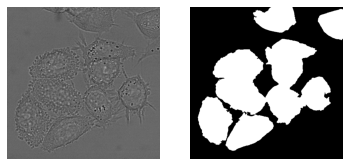

In [12]:
plt.subplot(1, 2, 1)
plt.imshow(x, cmap='gray')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(y, cmap='gray')
plt.axis('off');

# Zoom

Currently the images are too large:

In [13]:
x.shape

(512, 512)

We don't need such a resolution for our task. Let's downsample them:

In [14]:
from skimage.transform import rescale


class Zoom(Transform):
    _factor: float
    
    def image(image, _factor):
        return rescale(image.astype(float), _factor, order=1)
    
    def mask(mask, _factor):
        smooth = rescale(mask.astype(float), _factor, order=1)
        # the output will be a float ndarray, we need to convert it back to bool 
        return smooth >= 0.5

Here `image` and `mask` have different behaviour - the mask must also be binarized.

In [15]:
dataset = source >> Binarize() >> Zoom(factor=0.25)

x, y = dataset.image(key), dataset.mask(key)

In [16]:
x.shape

(128, 128)

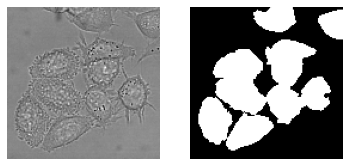

In [17]:
plt.subplot(1, 2, 1)
plt.imshow(x, cmap='gray')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(y, cmap='gray')
plt.axis('off');

# Crop

Next, we want to crop the image in order to remove the background. We'll use simple global thresholding for that:

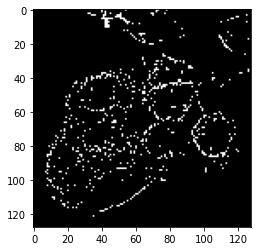

In [18]:
plt.imshow(x < 120, cmap='gray')

The black areas can be safely removed, because they don't contain cells:

In [19]:
from dpipe.im.box import mask2bounding_box
from dpipe.im import crop_to_box


class Crop(Transform):
    def image(image):
        box = mask2bounding_box(image < 120)
        return crop_to_box(image, box)
    
    def mask(mask, image):
        box = mask2bounding_box(image < 120)
        return crop_to_box(mask, box)

This is a more interesting operation, because the `mask` here depends on both the previous mask, and the previous image.

In [20]:
dataset = Chain(
    source, 
    Binarize(),
    Zoom(factor=0.25),
    Crop(),
)

x, y = dataset.image(key), dataset.mask(key)

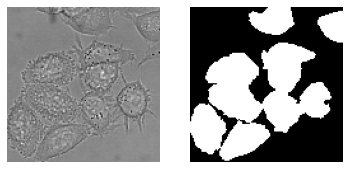

In [21]:
plt.subplot(1, 2, 1)
plt.imshow(x, cmap='gray')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(y, cmap='gray')
plt.axis('off');

Works like a charm, but now we have a bit of code duplication: 

```python
box = mask2bounding_box(image < 120)
```

this gets repeated twice. Let's fix that with a parameter:

In [22]:
class Crop(Transform):
    def _box(image):
        return mask2bounding_box(image < 120)
    
    def image(image, _box):
        return crop_to_box(image, _box)
    
    def mask(mask, _box):
        return crop_to_box(mask, _box)

that's better, but we still kinda have code duplication. We'll fix that in later tutorials.

In [23]:
dataset = Chain(
    source, 
    Binarize(),
    Zoom(factor=0.25),
    Crop(),
)

x, y = dataset.image(key), dataset.mask(key)

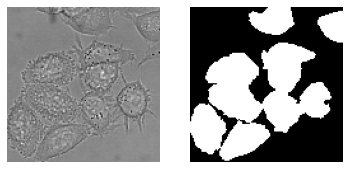

In [24]:
plt.subplot(1, 2, 1)
plt.imshow(x, cmap='gray')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(y, cmap='gray')
plt.axis('off');

Note how both the image and the mask got cropped. This is _data consistency_ at work!

# Dropping the Source

So far, all our pipelines used the `Source` as a starting layer, but this is not obligatory - you can build valid pipelines with only `Transform` layers:

In [25]:
processing = Chain(
    Binarize(),
    Zoom(factor=0.25),
    Crop(),
)

This is also a pipeline with `image` and `mask` as output:

In [26]:
dir(processing)

['image', 'mask']

What arguments do they expect?

In [27]:
# shift + tab shows: processing.image(image)
processing.image;

In order to get a processed image, we want an image as input. And for mask:

In [28]:
# shift + tab shows: processing.mask(image, mask)
processing.mask;

The mask also wants an `image` as input, why is that?

Remember the `Crop` layer? To compute the `mask` we needed the `_box`, which in turn needed the `image`. `connectome` automatically detects all the minimal dependencies for each field and that's why we have a function with two arguments!

Now we can use them directly:

In [29]:
# load the raw data
raw_x, raw_y = source.image(key), source.mask(key)
# apply processing
x = processing.image(raw_x)
y = processing.mask(image=raw_x, mask=raw_y)

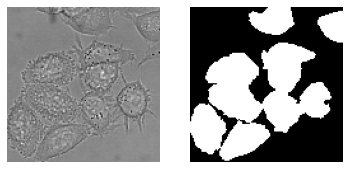

In [30]:
plt.subplot(1, 2, 1)
plt.imshow(x, cmap='gray')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(y, cmap='gray')
plt.axis('off');

That's all for now. See you next time!